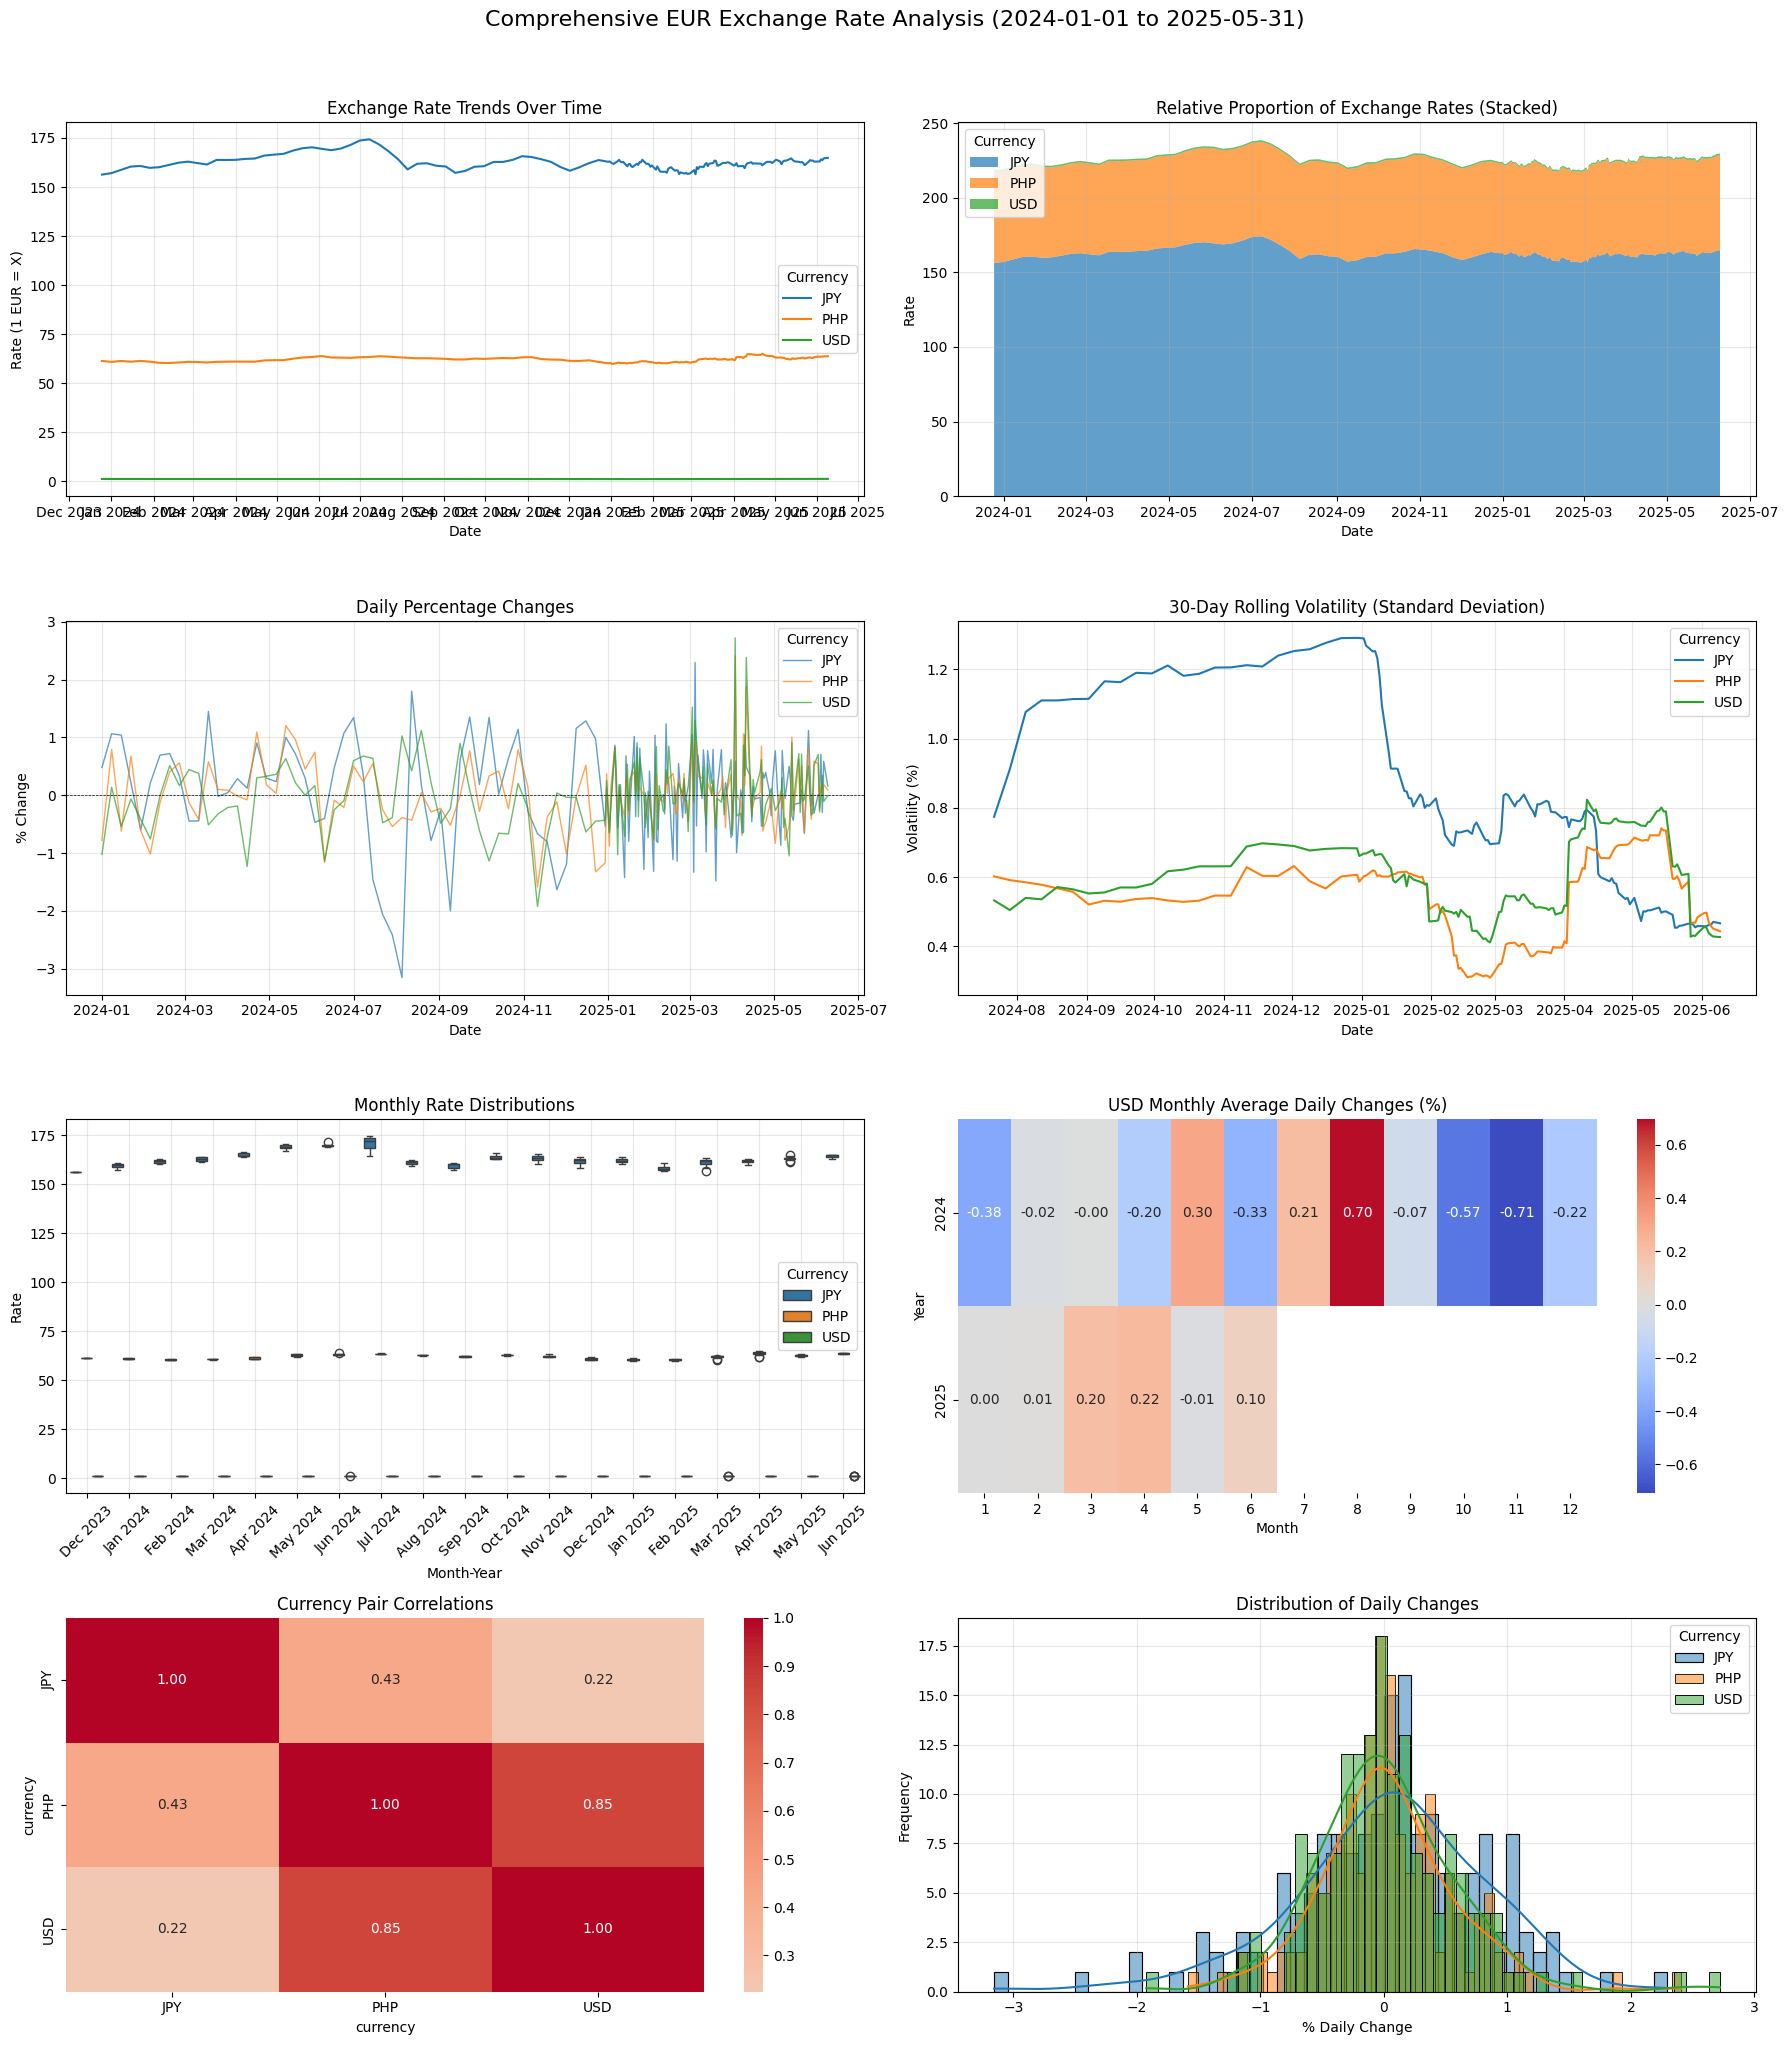


Summary Statistics:
currency         JPY         PHP         USD
count     166.000000  166.000000  166.000000
mean      162.144970   61.964726    1.083614
std         3.138978    1.295758    0.035894
min       156.330000   59.769000    1.023050
25%       160.445000   60.757750    1.047725
50%       162.145000   62.055000    1.083200
75%       163.292500   62.991000    1.112025
max       174.320000   64.963000    1.147600

Average Daily Changes:
currency         JPY         PHP         USD
count     165.000000  165.000000  165.000000
mean        0.035412    0.024802    0.021155
std         0.792959    0.544335    0.589822
min        -3.155266   -1.587527   -1.923966
25%        -0.370691   -0.290640   -0.318106
50%         0.074244   -0.001580   -0.009704
75%         0.498898    0.316530    0.309051
max         2.293930    2.409151    2.721466

Correlation Matrix:
currency       JPY       PHP       USD
currency                              
JPY       1.000000  0.430201  0.224838
PHP    

In [1]:
# 1. Imports and Setup
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sqlalchemy import create_engine
import os
from dotenv import load_dotenv
import numpy as np
from matplotlib.dates import MonthLocator, DateFormatter

# 2. Load environment variables
load_dotenv("/Users/Julie/currency_tracker/.env")

DB_HOST = os.getenv("DB_HOST")
DB_PORT = os.getenv("DB_PORT")
DB_NAME = os.getenv("DB_NAME")
DB_USER = os.getenv("DB_USER")
DB_PASSWORD = os.getenv("DB_PASSWORD")

# 3. Connect to PostgreSQL
engine = create_engine(f"postgresql://{DB_USER}:{DB_PASSWORD}@{DB_HOST}:{DB_PORT}/{DB_NAME}")

# 4. Load data into Pandas DataFrame
query = """
SELECT date, currency, rate
FROM exchange_rates
WHERE currency IN ('USD', 'JPY', 'PHP')
ORDER BY date, currency;
"""
df = pd.read_sql(query, engine)

# 5. Convert date column to datetime and add useful time-based columns
df['date'] = pd.to_datetime(df['date'])
df['month'] = df['date'].dt.month
df['year'] = df['date'].dt.year
df['year_month'] = df['date'].dt.to_period('M')
df['day_of_week'] = df['date'].dt.dayofweek  # Monday=0, Sunday=6

# 6. Pivot for plotting
pivot_df = df.pivot_table(index='date', columns='currency', values='rate', aggfunc='mean')

# 7. Calculate daily percentage changes
daily_changes = pivot_df.pct_change() * 100

# 8. Calculate monthly averages
monthly_avg = df.groupby(['year_month', 'currency'])['rate'].mean().unstack()

# 9. Calculate volatility (standard deviation of daily changes)
volatility = daily_changes.rolling(window=30).std()

# ============== Visualization Section ==============

# Set up the figure grid
plt.figure(figsize=(18, 20))
plt.suptitle("Comprehensive EUR Exchange Rate Analysis (2024-01-01 to 2025-05-31)", y=1.02, fontsize=16)

# Chart 1: Line Plot
plt.subplot(4, 2, 1)
for currency in pivot_df.columns:
    plt.plot(pivot_df.index, pivot_df[currency], label=currency, linewidth=1.5)
plt.title("Exchange Rate Trends Over Time")
plt.xlabel("Date")
plt.ylabel("Rate (1 EUR = X)")
plt.grid(True, alpha=0.3)
plt.legend(title="Currency")
plt.gca().xaxis.set_major_locator(MonthLocator())
plt.gca().xaxis.set_major_formatter(DateFormatter("%b %Y"))

# Chart 2: Stacked Area Chart
plt.subplot(4, 2, 2)
plt.stackplot(pivot_df.index, pivot_df.T, labels=pivot_df.columns, alpha=0.7)
plt.title("Relative Proportion of Exchange Rates (Stacked)")
plt.xlabel("Date")
plt.ylabel("Rate")
plt.legend(title="Currency", loc='upper left')
plt.grid(True, alpha=0.3)

# Chart 3: Daily Percentage Changes
plt.subplot(4, 2, 3)
for currency in daily_changes.columns:
    plt.plot(daily_changes.index, daily_changes[currency], label=currency, alpha=0.7, linewidth=1)
plt.title("Daily Percentage Changes")
plt.xlabel("Date")
plt.ylabel("% Change")
plt.axhline(0, color='black', linestyle='--', linewidth=0.5)
plt.grid(True, alpha=0.3)
plt.legend(title="Currency")

# Chart 4: 30-Day Rolling Volatility
plt.subplot(4, 2, 4)
for currency in volatility.columns:
    plt.plot(volatility.index, volatility[currency], label=currency, linewidth=1.5)
plt.title("30-Day Rolling Volatility (Standard Deviation)")
plt.xlabel("Date")
plt.ylabel("Volatility (%)")
plt.grid(True, alpha=0.3)
plt.legend(title="Currency")

# Chart 5: Boxplot of Monthly Distributions
plt.subplot(4, 2, 5)
monthly_df = df.copy()
monthly_df['month_year'] = monthly_df['date'].dt.strftime('%b %Y')
sns.boxplot(data=monthly_df, x='month_year', y='rate', hue='currency')
plt.title("Monthly Rate Distributions")
plt.xlabel("Month-Year")
plt.ylabel("Rate")
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.legend(title="Currency")

# Chart 6: Heatmap of Daily Changes
plt.subplot(4, 2, 6)
heatmap_data = daily_changes.copy()
heatmap_data['month'] = heatmap_data.index.month
heatmap_data['year'] = heatmap_data.index.year
heatmap_pivot = heatmap_data.pivot_table(index='year', columns='month', values='USD', aggfunc='mean')
sns.heatmap(heatmap_pivot, cmap='coolwarm', center=0, annot=True, fmt=".2f")
plt.title("USD Monthly Average Daily Changes (%)")
plt.xlabel("Month")
plt.ylabel("Year")

# Chart 7: Correlation Heatmap
plt.subplot(4, 2, 7)
corr_matrix = pivot_df.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, fmt=".2f")
plt.title("Currency Pair Correlations")

# Chart 8: Histogram of Daily Changes
plt.subplot(4, 2, 8)
for currency in daily_changes.columns:
    sns.histplot(daily_changes[currency], label=currency, kde=True, alpha=0.5, bins=50)
plt.title("Distribution of Daily Changes")
plt.xlabel("% Daily Change")
plt.ylabel("Frequency")
plt.legend(title="Currency")
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Additional Analysis: Summary Statistics
print("\nSummary Statistics:")
print(pivot_df.describe())

print("\nAverage Daily Changes:")
print(daily_changes.describe())

print("\nCorrelation Matrix:")
print(corr_matrix)

In [2]:
pip install seaborn

  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)
Note: you may need to restart the kernel to use updated packages.
